In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd 
from sklearn.decomposition import PCA

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm

# Load cleaned data from previous steps

In [3]:
#df_merged  = pd.read_csv('matches_merged.csv', low_memory=False)
df_merged = pd.read_csv('Data/matches_3.csv', low_memory=False)

In [4]:
def create_dataset(matches_merged:pd.DataFrame):
    # make these columns as string to apply one hot encoding
    matches_merged["country_id"] = matches_merged["country_id"].astype(str)
    matches_merged["league_id"] = matches_merged["league_id"].astype(str)
    matches_merged["match_api_id"] = matches_merged["match_api_id"].astype(str)
    matches_merged["home_team_api_id"] = matches_merged["home_team_api_id"].astype(str)
    matches_merged["away_team_api_id"] = matches_merged["away_team_api_id"].astype(str)
    matches_merged["season"] = matches_merged["season"].astype(str)
    for i in range(1,12):
        matches_merged[f"home_player_{i}"] = matches_merged[f"home_player_{i}"].astype(str)
        matches_merged[f"away_player_{i}"] = matches_merged[f"away_player_{i}"].astype(str)

    # add day/month/year
    # # Reformat the date column to extract year, month, and day
    # matches_merged["Year"] = matches_merged["date"].dt.year
    # matches_merged["Month"] = matches_merged["date"].dt.month
    # matches_merged["Day"] = matches_merged["date"].dt.day
    # create dataset
    #X = matches_merged.drop(columns = ["id", "home_team_goal", "away_team_goal", "date", "match_result", "goal_difference"])
    X = matches_merged.drop(columns = [ "match_result"])
    y = matches_merged["match_result"]
    
    # convert non_num_columns to str
    non_numeric_columns = X.select_dtypes(include=['object']).columns.tolist()
    X[non_numeric_columns] = X[non_numeric_columns].astype(str)

    # label encoding
    for col in non_numeric_columns:
        encoder = LabelEncoder()
        X[col] = encoder.fit_transform(X[col])


    # encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
    # encoded_dataset = encoder.fit_transform(X[non_numeric_columns])
    # encoded_df = pd.DataFrame(encoded_dataset, columns=encoder.get_feature_names_out(non_numeric_columns), index=X.index)
    # # Drop the original non-numeric columns and concatenate the one-hot encoded ones
    # X = pd.concat([X.drop(non_numeric_columns, axis=1), encoded_df], axis=1)

    return X,y

In [5]:
# get dataset and split them
X,y = create_dataset(df_merged)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA analysis

## PCA for Betting Odds

[0.98629995 0.00478215 0.00266973 0.00237749 0.00219219 0.00167848]
[0.97138127 0.00913194 0.00725802 0.00512668 0.00387707 0.00322502]
[0.97358727 0.00736171 0.00669835 0.0049297  0.00389324 0.00352972]


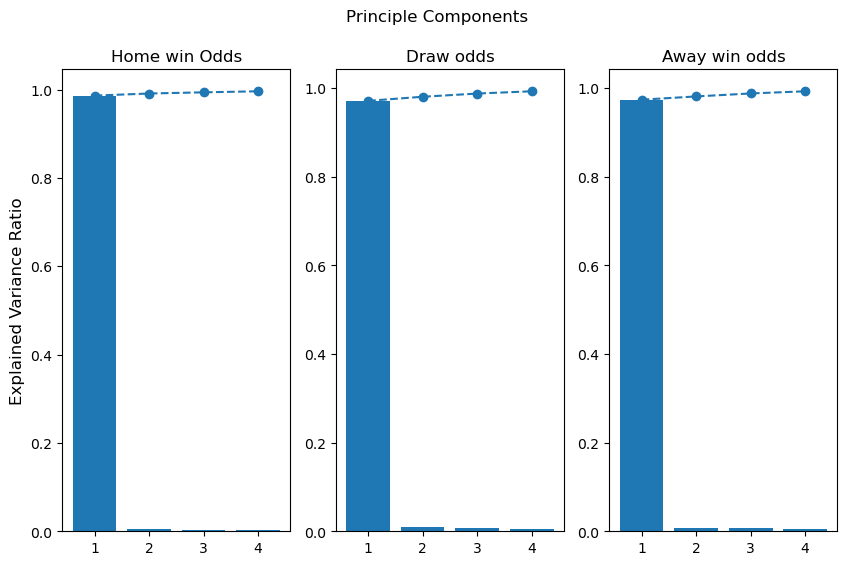

In [6]:
def createBettingPCA(X_train):
    betting_company = ['B365','BW','IW','LB','VC','WH']
    pca_dict = {}
    for odds in ['H','D','A']:
        betting_list = [x + odds for x in betting_company]
        pca = PCA()

        scaler = StandardScaler()
        X_scaler = scaler.fit_transform(X_train[betting_list])
        pca.fit(X_scaler)
        pca_dict[odds] = pca
    
    return pca_dict

betting_pca_dict = createBettingPCA(X_train_org)

# now we have a look on each betting odds
plt.figure(1,figsize=(10,6))
plt.suptitle("Principle Components")
for i,tag in enumerate(['H','D','A']):

    # Explained variance ratio
    explained_variance_ratio = betting_pca_dict[tag].explained_variance_ratio_
    print(explained_variance_ratio)

    # Set the number of components to display
    n_components_to_display = 4

    # Define the x-tick step 
    x_tick_step = 10 

    # Scree plot with a limited number of components
    plt.subplot(1,3,i+1)
    plt.plot(
        range(1, n_components_to_display + 1),
        explained_variance_ratio.cumsum()[:n_components_to_display],
        marker='o',
        linestyle='--',
        label='Cumulative Variance'
    )
    plt.bar(
        range(1, n_components_to_display + 1),
        explained_variance_ratio[:n_components_to_display],
        label='Individual Variance'
    )

    labels = {
        "H":"Home win Odds",
        "D": "Draw odds",
        "A": "Away win odds"
    }

    # Add title and labels
    #plt.title("Top Components", fontsize=14)
    plt.title(f"{labels[tag]}", fontsize=12)
    if i == 0:
        plt.ylabel("Explained Variance Ratio", fontsize=12)

    # Adjust x-ticks to show only specific labels
    # plt.xticks(
    #     ticks=range(0, n_components_to_display + 1, x_tick_step),
    #     labels=range(0, n_components_to_display + 1, x_tick_step),
    #     fontsize=10
    # )


## PCA for players

display 26
display 25
display 26
display 25


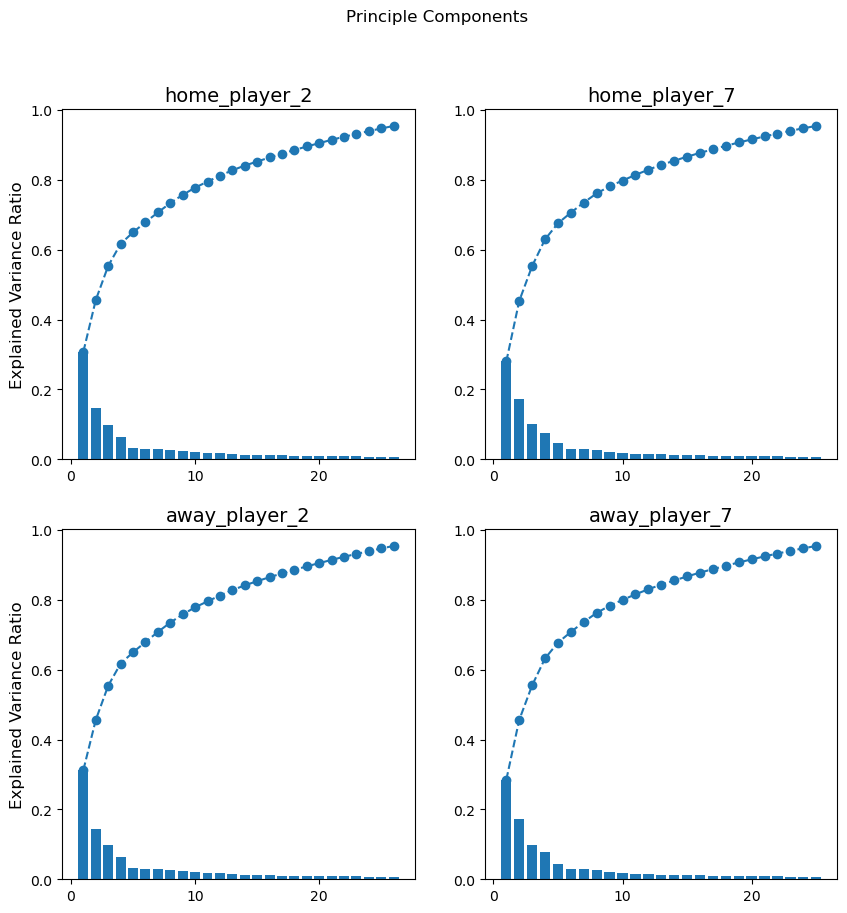

In [7]:
# player attributes PCA
def createPlayerPCA(X_train):
    features = [x.split('home_player_6_')[-1] for x in X.columns if ('home_player_6_' in x) and ('.0' not in x) ]
    pca_dict = {}
    for i in range(2,12):
        for tag in ['home','away']:
            player_columns = [f'{tag}_player_{i}_{f}' for f in features]
            pca = PCA()

            scaler = StandardScaler()
            X_scaler = scaler.fit_transform(X_train[player_columns])
            pca.fit(X_scaler)
            pca_dict[f'{tag}_player_{i}'] = pca
    
    return pca_dict

player_pca_dict = createPlayerPCA(X_train_org)

# play some features
plt.figure(2,figsize=(10,10))
c = 0
plt.suptitle("Principle Components")
for tag in ['home','away']:
    for i in [2,7]:
        # Explained variance ratio
        explained_variance_ratio = player_pca_dict[f'{tag}_player_{i}'].explained_variance_ratio_

        # Set the number of components to display
        n_components_to_display = np.where(explained_variance_ratio.cumsum() > 0.95)[0][0] + 1
        print(f'display {n_components_to_display}')

        # Define the x-tick step 
        x_tick_step = 10 

        # Scree plot with a limited number of components
        plt.subplot(2,2,c + 1)
        c = c + 1
        plt.plot(
            range(1, n_components_to_display + 1),
            explained_variance_ratio.cumsum()[:n_components_to_display],
            marker='o',
            linestyle='--',
            label='Cumulative Variance'
        )
        plt.bar(
            range(1, n_components_to_display + 1),
            explained_variance_ratio[:n_components_to_display],
            label='Individual Variance'
        )

        # Add title and labels
        plt.title(f"{tag}_player_{i}", fontsize=14)
        # plt.xlabel(f"Principal Components for ", fontsize=12)
        if (c-1)%2 == 0: plt.ylabel("Explained Variance Ratio", fontsize=12)

        # Adjust x-ticks to show only specific labels
        plt.xticks(
            ticks=range(0, n_components_to_display + 1, x_tick_step),
            labels=range(0, n_components_to_display + 1, x_tick_step),
            fontsize=10
        )

# Feature Engineering

In [8]:
# now do feature engineering:
def feature_engineering(X_org,betting_pca_dict:dict,player_pca_dict:dict):
    # backup original data
    X = X_org.copy()

    # transform betting odds to charact
    # eristic features
    betting_company = ['B365','BW','IW','LB','VC','WH']
    n_comps_betting = 1
    for odds in ['H','D','A']:
        cols = [x + odds for x in betting_company]
        scaler = StandardScaler()
        X_scaler = scaler.fit_transform(X[cols])
        X1 = betting_pca_dict[odds].transform(X_scaler)
        pca_df = pd.DataFrame(X1[:,:n_comps_betting],columns=[f'Betting_feature_{odds}_{i+1}' for i in range(n_comps_betting)],index=X.index)
        X = pd.concat([X.drop(cols, axis=1), pca_df], axis=1)
    
    # tranform player features
    n_comps_player = 25
    features = [x.split('home_player_6_')[-1] for x in X.columns if ('home_player_6_' in x) and ('.0' not in x) ]
    for i in range(2,12):
        for tag in ['home','away']:
            player_columns = [f'{tag}_player_{i}_{f}' for f in features]
            scaler = StandardScaler()
            X_scaler = scaler.fit_transform(X[player_columns])
            X1 = player_pca_dict[f'{tag}_player_{i}'].transform(X_scaler)
            pca_df = pd.DataFrame(X1[:,:n_comps_player],columns=[f'{tag}_player_{i}_feature_{j+1}' for j in range(n_comps_player)],index=X.index)
            X = pd.concat([X.drop(player_columns, axis=1), pca_df], axis=1)
    
    # drop player 1 
    for i in range(1,2):
        for tag in ['home','away']:
            player_columns = [f'{tag}_player_{i}_{f}' for f in features]
            X = X.drop(player_columns,axis=1)

    return X

X_train = feature_engineering(X_train_org,betting_pca_dict,player_pca_dict)

In [9]:
# feature engineering for test data
X_test = feature_engineering(X_test_org,betting_pca_dict,player_pca_dict)

# Random Forest 

In [10]:
# now let's train a random forest model
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [11]:
# print accuracy
print(accuracy_score(y_test,forest.predict(X_test)))

0.5126272144741801


## display important features

In [ ]:
# plot the importance of each feature
import seaborn as sns 

importance_df = pd.DataFrame({
    "Feature":X_train.columns,
    "Importance":forest.feature_importances_
})
importance_df = importance_df.sort_values(by="Importance",ascending=False)

# plot figures
plt.figure(4,figsize=(5,5))
sns.barplot(x="Importance",y="Feature",data=importance_df.head(20))
plt.title("Most Important Features")

plt.figure(5,figsize=(5,5))
sns.barplot(x="Importance",y="Feature",data=importance_df.tail(20))
plt.title("Most unimportant Features")
plt.show()

# cross validation of different models

In [12]:
# load several classifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [13]:
classifiers = {
    "GB": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "GNB": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "ABC": AdaBoostClassifier(random_state=42)
}

# Evaluate classifiers using cross-validation
results = {}
for name, clf in classifiers.items():
    print(name)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')  # Change 'accuracy' to desired metric
    results[name] = (scores.mean(), scores.std())

# Print results
print("Classifier Comparison:")
for name, (mean, std) in results.items():
    print(f"{name}: Mean accuracy = {mean:.3f}, Std = {std:.3f}")

GB
Random Forest
GNB
KNN
ABC


/home/nqdu/.conda/envs/cme/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/nqdu/.conda/envs/cme/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/nqdu/.conda/envs/cme/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/nqdu/.conda/envs/cme/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Classifier Comparison:
GB: Mean accuracy = 0.527, Std = 0.003
Random Forest: Mean accuracy = 0.523, Std = 0.003
GNB: Mean accuracy = 0.492, Std = 0.004
KNN: Mean accuracy = 0.420, Std = 0.003
ABC: Mean accuracy = 0.510, Std = 0.004


In [14]:
results

{'GB': (0.5265838540229411, 0.0027640712937313946),
 'Random Forest': (0.5233783968136951, 0.003043731630064025),
 'GNB': (0.491610442853899, 0.0043259740289625665),
 'KNN': (0.4203430885703353, 0.003235453052899723),
 'ABC': (0.5098042509246212, 0.004164672542110715)}

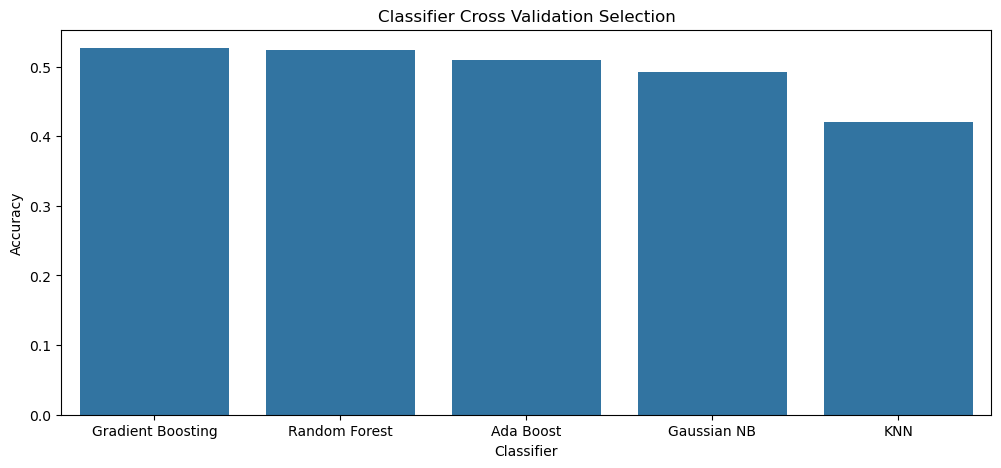

In [16]:
import seaborn as sns 
model_df = pd.DataFrame({
    "Classifier":["Random Forest","Gradient Boosting","Gaussian NB","KNN","Ada Boost"],
    "Accuracy":[results['Random Forest'][0],results['GB'][0],
                results['GNB'][0],results['KNN'][0],results['ABC'][0]]
})

model_df.sort_values(by="Accuracy",ascending=False,inplace=True)

plt.figure(5,figsize=(12,5))
sns.barplot(data=model_df,x="Classifier",y="Accuracy")
plt.title("Classifier Cross Validation Selection")
plt.xlabel("Classifier")
plt.show()
model_df.to_csv("Data/classifier_selection.csv")

# cross validation of Hyperparameters

In [17]:
model = RandomForestClassifier(random_state=42)

# Define the parameter grid (optimized for memory)
param_distributions = {
    'n_estimators': [10,50, 100, 500],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1  
)

# Fit on the training data
search.fit(X_train, y_train)

# Evaluate the best model
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   1.9s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   1.9s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   2.0s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   2.1s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   2.1s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.9s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.9s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.0s
[

In [18]:
# save Random forest parameters
import json
f = open("Data/best_model.json","w")
json.dump(best_model.get_params(),f)
f.close()

# plot confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

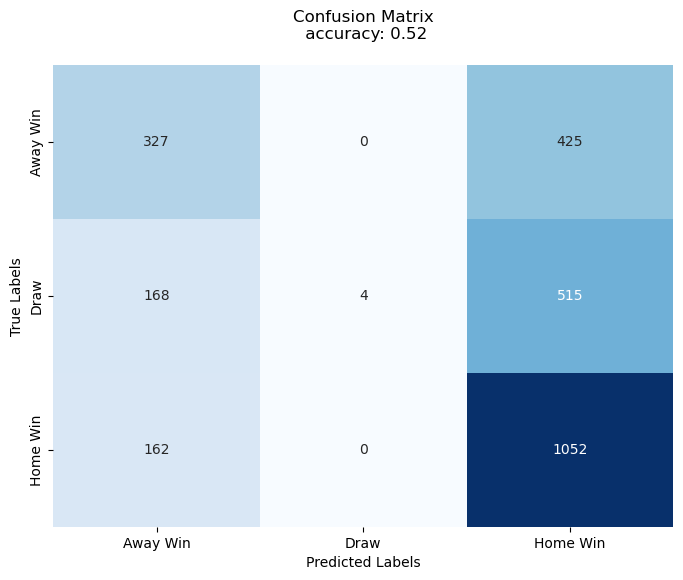

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Get the classification report
class_report = classification_report(y_test, y_pred)

# PLOT CONFUSION MATRIX
class_names = forest.classes_


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix\n accuracy: {:.2f}\n'.format(accuracy_score(y_test,y_pred)))
plt.savefig('confusion_matrix.png', dpi = 600)
plt.show()

#Just run this on you result and give me the new figure plese